In [1]:
%load_ext autoreload
%autoreload 2

import os

import numpy as np
import pandas as pd
import wandb
import xarray as xr

from functools import partial
from dask.diagnostics import ProgressBar

import matplotlib
from matplotlib import pyplot as plt
import matplotlib.ticker

from fme_diags.utils import (
    get_run_kwargs, get_wandb_path,
    load_config, load_global_time_mean_metrics, 
    open_autoregressive_inference, open_reference,
)

_ = xr.set_options(keep_attrs=True)

wandb.login()

In [65]:
FULL_RETRAINING = "42yrs-batch_size8-max_epochs50-lr3e-4-run4-ema"
FINETUNING = "fv3gfs_finetune_embed_block7_dec_lr3e-4_ep10-run00"
ZERO_SHOT = "fv3gfs_zero_shot-run00"
REF = "42-years-training-set-reference"

RUN_LABELS = {
    FULL_RETRAINING: "Full retraining", 
    FINETUNING: "FV3GFS-to-EAMv2\nfinetuning", 
    ZERO_SHOT: "FV3GFS-to-EAMv2 zero shot", 
    REF: "EAMv2 reference",
}

# FV3GFS = "retrain-30e-rs1-10yr-ema"

In [4]:
config = load_config("./preds.yaml")
run_kwargs = get_run_kwargs(config, FULL_RETRAINING)
ds = open_autoregressive_inference(**run_kwargs)

In [8]:
PRECIP = "surface_precipitation_rate"
PS = "PS"
OLR = "FLUT"
OSR = "top_of_atmos_upward_shortwave_flux"  
TWP_ADV = "tendency_of_total_water_path_due_to_advection"

PS_FACTOR = 0.01 
PS_UNITS = "hPa"

PRECIP_FACTOR = 86400.0
PRECIP_UNITS = "mm/day"

FLUX_UNITS = "W/m$^2$"

variables = config["variables"]
prognostic_vars = variables["labels"]["prognostic"]
diagnostic_vars = variables["labels"]["diagnostic"]
all_vars = {
    **prognostic_vars,
    **diagnostic_vars,
}

fv3gfs_variables = variables["fv3gfs"]
all_vars_fv3gfs = {
    **fv3gfs_variables["prognostic"],
    **fv3gfs_variables["diagnostic"],
}
fv3gfs_vars_dict = {v: all_vars[k] for k, v in all_vars_fv3gfs.items()}

wandb_inf_keys_stems = config["wandb_metrics"]["inference"]

all_units = {varname: ds[varname].units for varname in all_vars.keys()}
all_units[PRECIP] = PRECIP_UNITS
all_units[TWP_ADV] = PRECIP_UNITS
all_units[PS] = PS_UNITS

for k, v in all_units.items():
    if v == "W/m2":
        all_units[k] = FLUX_UNITS
        
all_units = pd.DataFrame.from_dict(all_units, orient="index", columns=["units"])

def rescale_variable(x, factor: float, units=None):
    x = x * factor
    if isinstance(x, xr.DataArray):
        x = x.assign_attrs(units=units)
    return x

UNIT_CONVERSIONS = {
    PRECIP: partial(rescale_variable, factor=PRECIP_FACTOR, units=PRECIP_UNITS),
    TWP_ADV: partial(rescale_variable, factor=PRECIP_FACTOR, units=PRECIP_UNITS),
    PS: partial(rescale_variable, factor=PS_FACTOR, units=PS_UNITS),
}

In [9]:
%%time

api = wandb.Api()

inf_runs = {
    key: api.run(get_wandb_path(config, key))
    for key in RUN_LABELS.keys()
}

inf_bias = {
    key: load_global_time_mean_metrics(
        wandb_run=run, 
        keys_stem=wandb_inf_keys_stems["bias"],
        vars_dict=all_vars, 
        run_label=RUN_LABELS[key],
        apply_funcs=UNIT_CONVERSIONS,
    )
    for key, run in inf_runs.items()
}

inf_rmse = {
    key: load_global_time_mean_metrics(
        wandb_run=run, 
        keys_stem=wandb_inf_keys_stems["rmse"],
        vars_dict=all_vars, 
        run_label=RUN_LABELS[key],
        apply_funcs=UNIT_CONVERSIONS,
    )
    for key, run in inf_runs.items()
}

CPU times: user 254 ms, sys: 28.6 ms, total: 282 ms
Wall time: 5.52 s


In [66]:
zero_shot_bias = inf_bias[ZERO_SHOT].iloc[:,0]

inf_bias_norm = pd.concat({
    RUN_LABELS[key]: df.iloc[:,0] / zero_shot_bias
    for key, df in inf_bias.items()
    if key != ZERO_SHOT
}, axis=1)

inf_bias_norm["label"] = inf_bias[ZERO_SHOT]["label"]
inf_bias_norm

,Full retraining,FV3GFS-to-EAMv2\nfinetuning,EAMv2 reference,label
PS,0.001641,-0.200364,0.000324,$p_s$
U_0,0.565852,-0.038287,-0.014913,$U_0$
U_1,0.282233,-0.204694,0.031590,$U_1$
U_2,1.129362,0.645796,0.108220,$U_2$
U_3,-0.156954,-0.585915,-0.028255,$U_3$
U_4,0.027931,-0.318675,-0.016990,$U_4$
U_5,0.116259,0.050937,-0.005726,$U_5$
U_6,0.039613,0.091780,0.008911,$U_6$
U_7,0.003216,0.073601,0.008920,$U_7$
V_0,-0.020563,-1.878711,0.035317,$V_0$


In [67]:
zero_shot_rmse = inf_rmse[ZERO_SHOT].iloc[:,0]

inf_rmse_norm = pd.concat({
    RUN_LABELS[key]: df.iloc[:,0] / zero_shot_rmse
    for key, df in inf_rmse.items()
    if key != ZERO_SHOT
}, axis=1)

inf_rmse_norm["label"] = inf_rmse[ZERO_SHOT]["label"]
inf_rmse_norm

,Full retraining,FV3GFS-to-EAMv2\nfinetuning,EAMv2 reference,label,units
PS,0.034492,0.048620,0.023084,$p_s$,hPa
U_0,0.209631,0.258470,0.079755,$U_0$,m/s
U_1,0.196063,0.197435,0.063588,$U_1$,m/s
U_2,0.193473,0.241536,0.079145,$U_2$,m/s
U_3,0.212756,0.309335,0.108891,$U_3$,m/s
U_4,0.240618,0.324562,0.139399,$U_4$,m/s
U_5,0.253854,0.317492,0.134228,$U_5$,m/s
U_6,0.210725,0.301999,0.113449,$U_6$,m/s
U_7,0.185380,0.240461,0.106514,$U_7$,m/s
V_0,0.225177,0.424480,0.165786,$V_0$,m/s


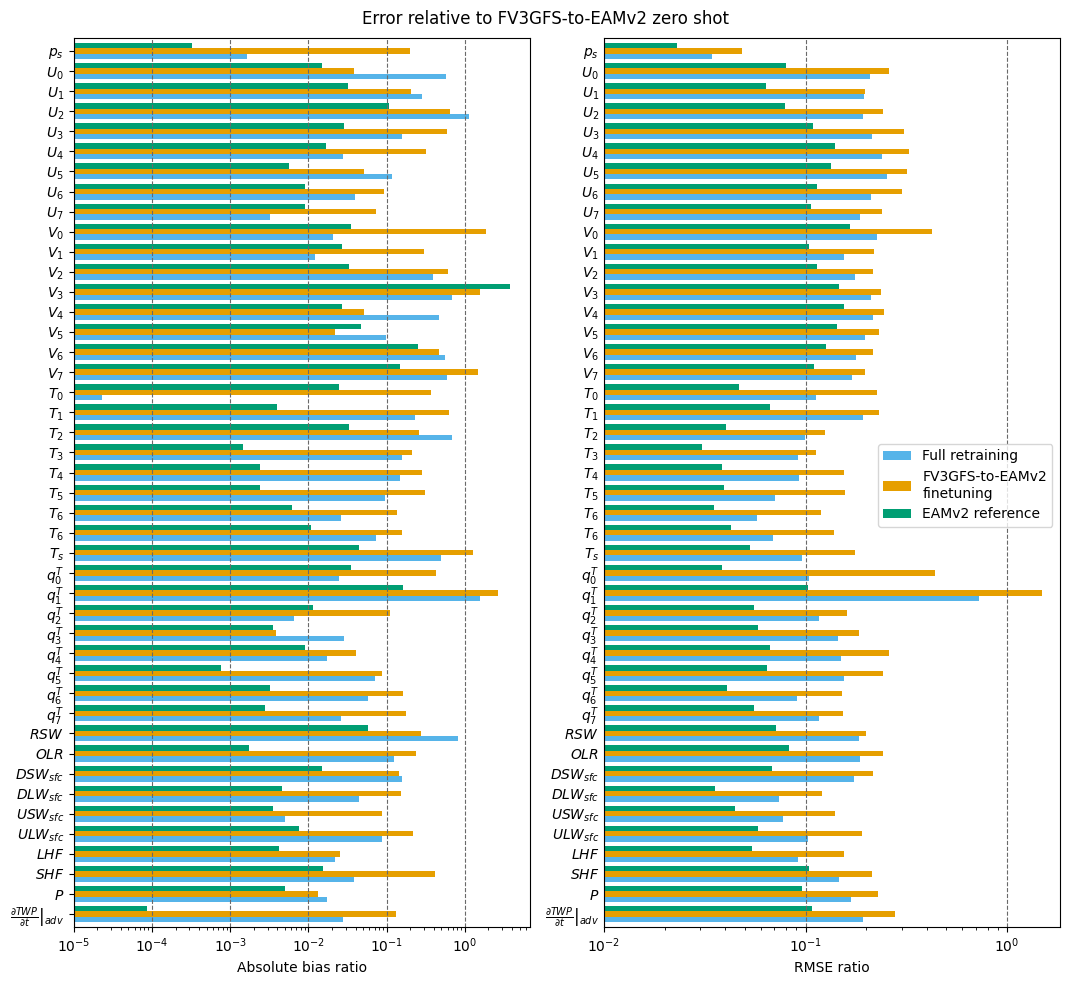

In [83]:
order = list(all_vars.keys())[::-1]

abs_bias_ordered = np.abs(inf_bias_norm.loc[order].set_index("label"))
rmse_ordered = inf_rmse_norm.loc[order].set_index("label")

fig, axs = plt.subplots(1, 2, figsize=(11, 10))
abs_bias_ordered.plot.barh(ax=axs[0], logx=True, legend=False, width=0.8)
rmse_ordered.plot.barh(ax=axs[1], logx=True, legend=False, width=0.8)

axs[0].set_xticks(np.logspace(-5, 0, 6))
axs[0].set_xlabel('Absolute bias ratio')
axs[0].set_ylabel('')

axs[1].set_xticks(np.logspace(-2, 0, 3))
axs[1].set_xlabel('RMSE ratio')
axs[1].yaxis.set_tick_params(labelleft=True, labelright=False, length=0.0)
axs[1].set_ylabel('')

for ax in axs:
    ax.grid(axis="x", linestyle="--", color="dimgray")
    
axs[1].legend(loc=(0.6, 0.45))

plt.suptitle("Error relative to FV3GFS-to-EAMv2 zero shot")    
plt.tight_layout()